In [18]:
import Pkg; Pkg.activate("..")

  Activating project at `~/SAFT_ML`


In [19]:
using CSV, DataFrames, DelimitedFiles, Clapeyron, PyCall, LinearAlgebra
import PyPlot; const plt = PyPlot ;

In [20]:
raw_data = CSV.read("SI_pcp-saft_parameters.csv",DataFrame,header=1) ;
fieldnames(typeof(raw_data))
#display(names(df)[1:20]) ;
writedlm("out.txt", names(raw_data), ' ') ;

replace!(raw_data.mu, missing => 0) ;
replace!(raw_data.kappa_ab, missing => 0) ;
replace!(raw_data.epsilon_k_ab, missing => 0) ;

raw_data.mu = Float64.(raw_data.mu)
raw_data.kappa_ab = Float64.(raw_data.kappa_ab)
raw_data.epsilon_k_ab = Float64.(raw_data.epsilon_k_ab) ;
raw_data = sort(raw_data, :molarweight) ;

In [21]:
# Info for Clapeyron Database File:
# species Mw segment sigma epsilon dipole n_H n_e source
num_rows = nrow(raw_data)
processed_data = DataFrame(
    species = fill(missing, num_rows),
    isomeric_SMILES = fill(missing, num_rows), 
    family = fill(missing, num_rows),
    Mw = fill(missing, num_rows),
    segment = fill(missing, num_rows),
    sigma = fill(missing, num_rows),
    epsilon = fill(missing, num_rows),
    dipole = fill(missing, num_rows),
    kappa_ab = fill(missing, num_rows),
    epsilon_k_ab = fill(missing, num_rows),
    na = fill(missing, num_rows),
    nb = fill(missing, num_rows),
    interaction = fill(missing,num_rows),
    bounds_violation = fill(missing,num_rows),
    source = fill(missing, num_rows)
) ;

In [22]:
processed_data.species = raw_data.common_name
processed_data.Mw = raw_data.molarweight
processed_data.isomeric_SMILES = raw_data.isomeric_smiles
processed_data.family = raw_data.family
processed_data.segment = raw_data.m
processed_data.sigma = raw_data.sigma
processed_data.epsilon = raw_data.epsilon_k
processed_data.dipole = raw_data.mu
processed_data.kappa_ab = raw_data.kappa_ab
processed_data.epsilon_k_ab = raw_data.epsilon_k_ab
processed_data.na = raw_data.na
processed_data.nb = raw_data.nb
processed_data.interaction = raw_data.opt
processed_data.bounds_violation = raw_data.bounds_violation
processed_data[!, :source] .= "10.1021/acs.iecr.3c02255" ;

processed_data

Row,species,isomeric_SMILES,family,Mw,segment,sigma,epsilon,dipole,kappa_ab,epsilon_k_ab,na,nb,interaction,bounds_violation,source
,String,String,String31,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Int64,String15,String,String
1,methane,C,Alkanes,16.031,1.0,3.70051,150.071,0.0,0.0,0.0,0,0,NONPOLAR,m: lower,10.1021/acs.iecr.3c02255
2,ammonia,N,Inorganic compounds,17.027,2.44608,2.3709,213.571,0.0,0.0001,200.0,1,1,ASSOCIATIVE,"kappa_ab: lower, epsilon_k_ab: lower",10.1021/acs.iecr.3c02255
3,ammonia-d3,[2H]N([2H])[2H],Other compounds,17.027,2.77559,2.0918,129.266,0.0,0.9,1233.56,1,1,ASSOCIATIVE,kappa_ab: higher,10.1021/acs.iecr.3c02255
4,water,O,Inorganic compounds,18.011,2.36948,2.15072,230.716,0.0,0.35319,2195.1,1,1,ASSOCIATIVE,OK,10.1021/acs.iecr.3c02255
5,tritium oxide,[3H]O[3H],Other compounds,18.011,2.63111,1.99608,344.334,0.0,0.0,0.0,0,0,NONPOLAR,OK,10.1021/acs.iecr.3c02255
6,hydrogen fluoride,F,Inorganic compounds,20.006,1.23675,2.90791,322.584,1.82,0.0,0.0,0,0,DIPOLAR,OK,10.1021/acs.iecr.3c02255
7,ethyne,C#C,Alkynes,26.016,2.22087,2.87502,166.034,0.0,0.0,0.0,0,0,NONPOLAR,OK,10.1021/acs.iecr.3c02255
8,hydrogen cyanide,C#N,Nitriles,27.011,2.72334,2.64506,170.345,2.98,0.0,0.0,1,0,DIPOLAR,OK,10.1021/acs.iecr.3c02255
9,carbon monoxide,[C-]#[O+],Inorganic compounds,27.995,1.32286,3.24532,91.1709,0.0,0.0,0.0,0,0,NONPOLAR,OK,10.1021/acs.iecr.3c02255


In [23]:
filtered_data_chem_family = filter(row -> occursin("Alkane", row.family), processed_data) ;
filtered_data_chem_family = sort(filtered_data_chem_family, :Mw) 

species_names = filtered_data_chem_family.species ;

#println(filtered_data_chem_family)

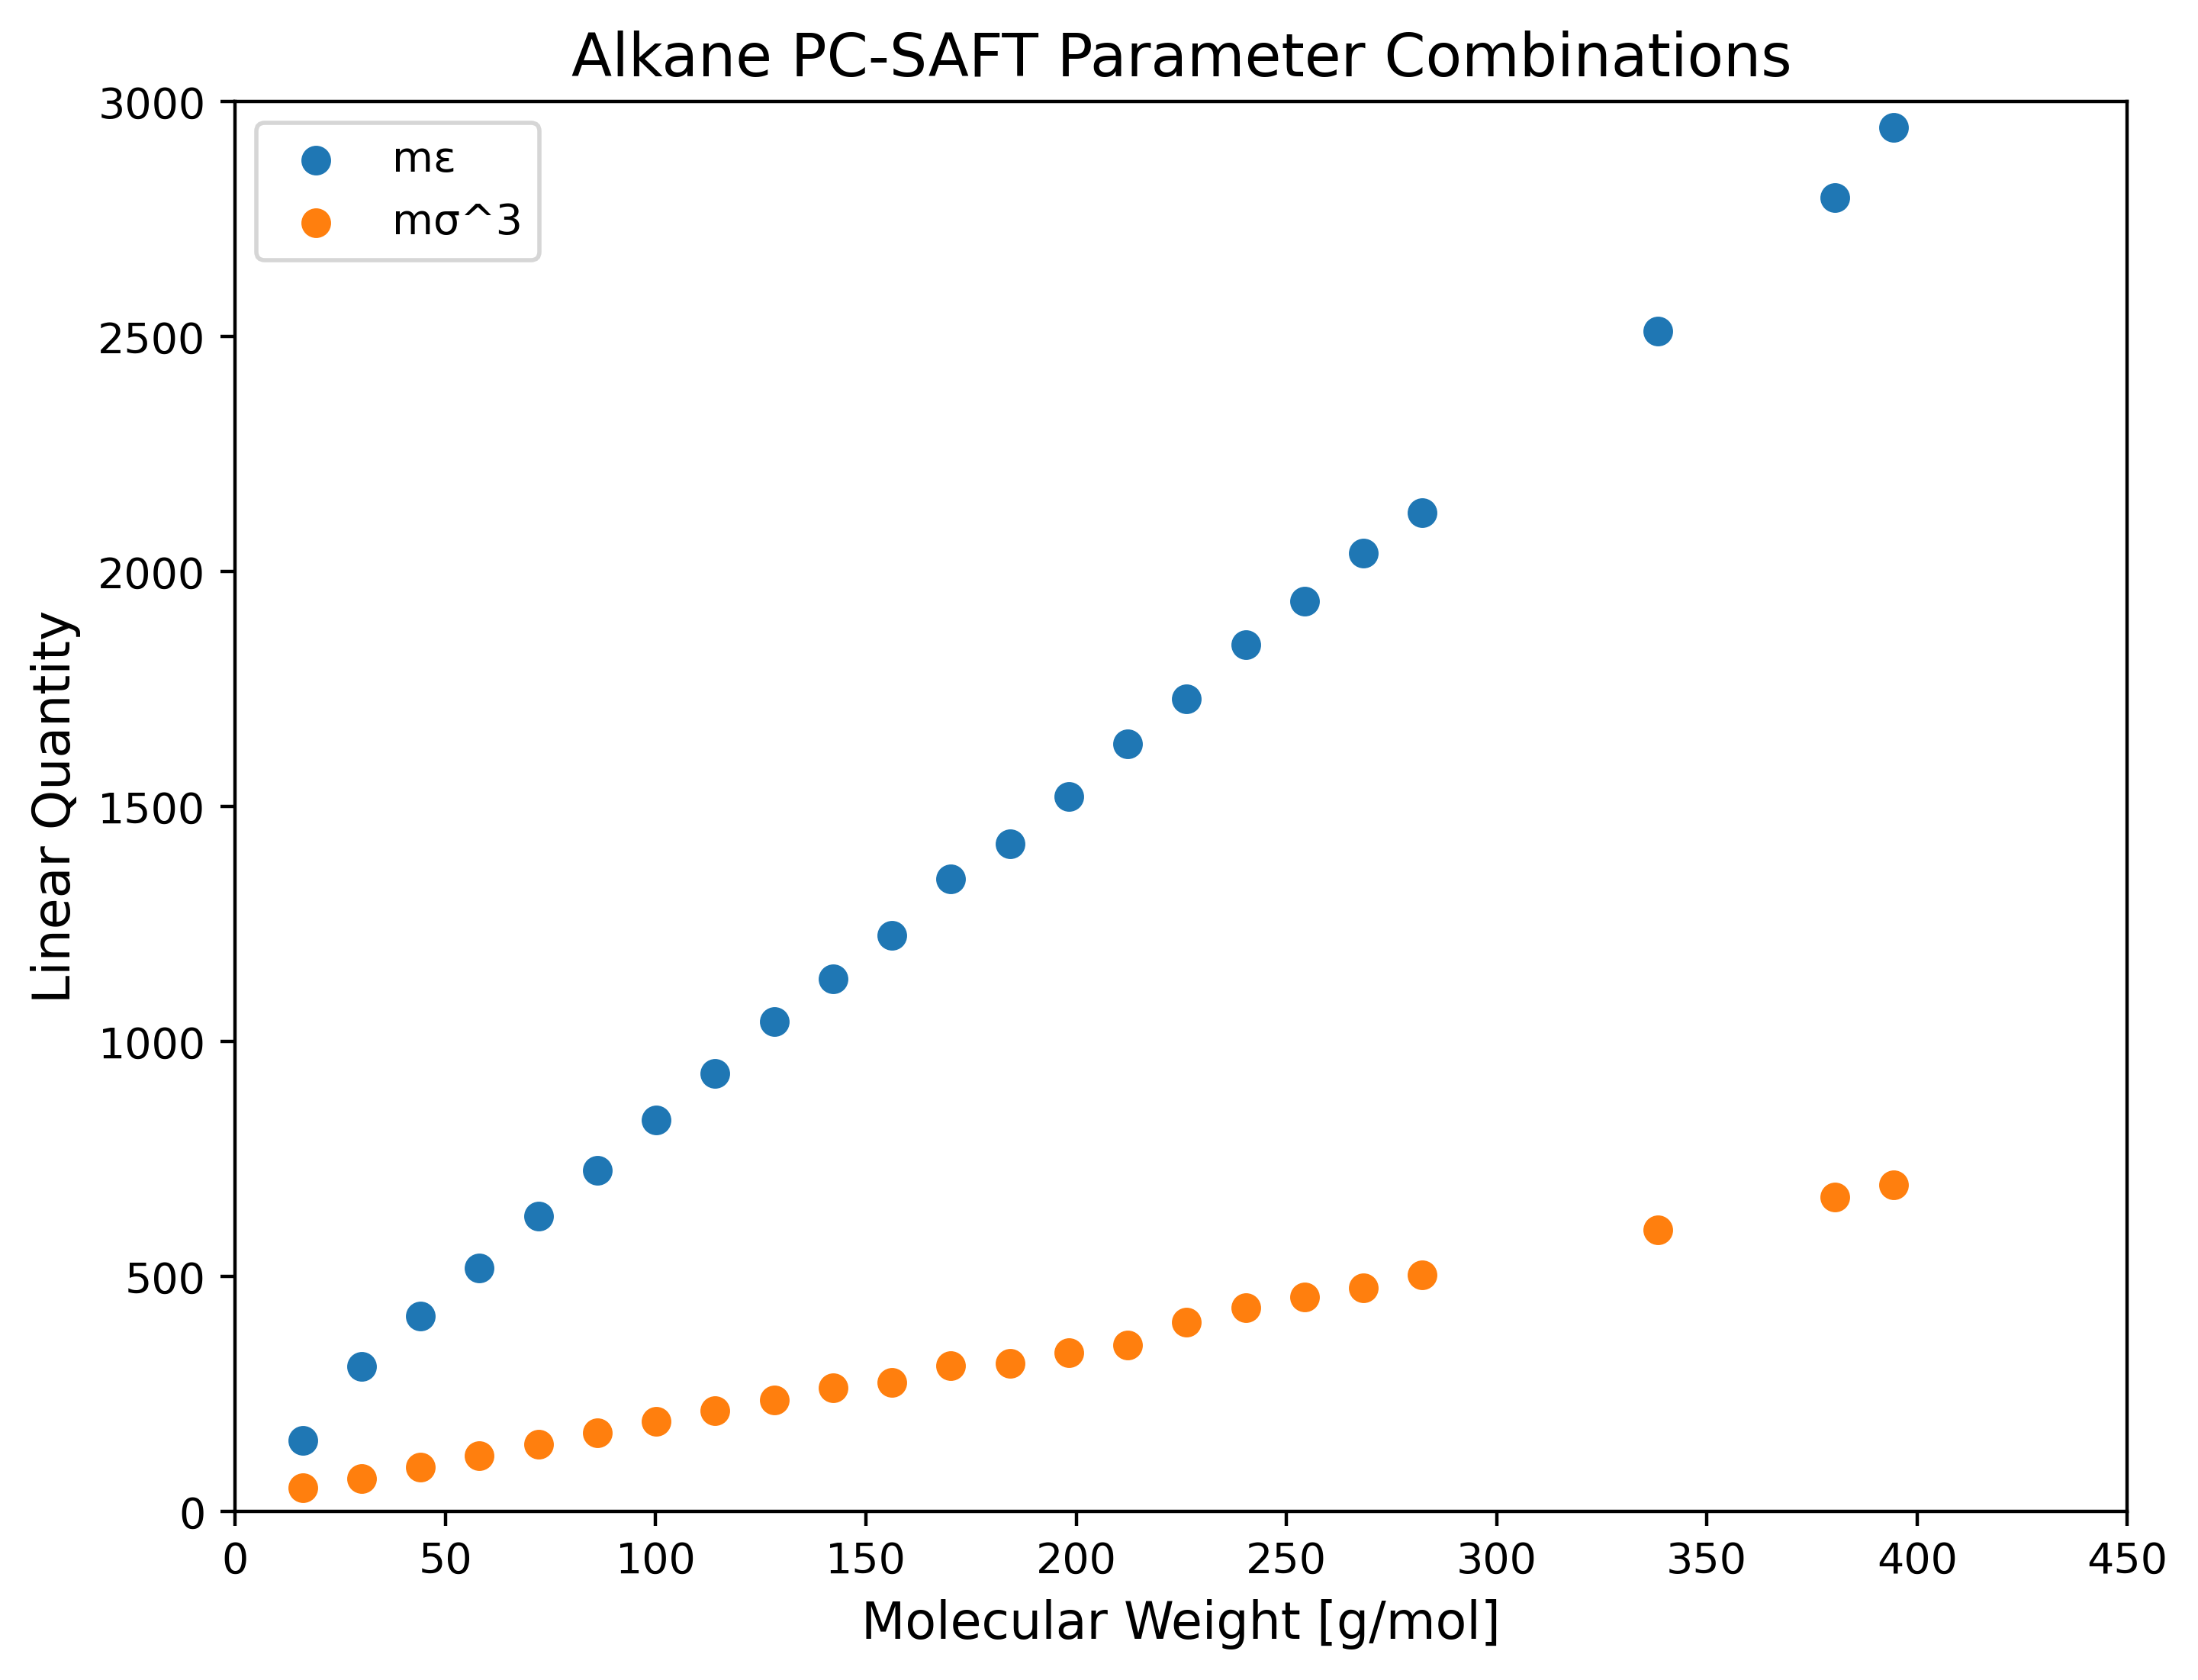

In [24]:
contains_only_c(name) = all(letter -> lowercase(letter) == 'c', name) ;
filtered_data_unbranched_alkanes = filter(row -> contains_only_c(row.isomeric_smiles), raw_data) 

m_sigmacubed = []
for (a, b) in zip(filtered_data_unbranched_alkanes.m, filtered_data_unbranched_alkanes.sigma)
    push!(m_sigmacubed, a*b^3)
end

m_epsilon = []
for (a, b) in zip(filtered_data_unbranched_alkanes.m, filtered_data_unbranched_alkanes.epsilon_k)
    push!(m_epsilon, a*b)
end

plt.figure(figsize=(8, 6), dpi=400)

plt.scatter(filtered_data_unbranched_alkanes.molarweight, m_epsilon, label="mε")
plt.scatter(filtered_data_unbranched_alkanes.molarweight, m_sigmacubed, label="mσ^3")
plt.xlabel("Molecular Weight [g/mol]",fontsize=12)
plt.ylabel("Linear Quantity",fontsize = 12)
plt.legend(["mε","mσ^3"])
plt.title("Alkane PC-SAFT Parameter Combinations",fontsize=14)
plt.xlim(0,450)
plt.ylim(0,3000) ;

plt.savefig("Linear_Quantities_Winter.png",dpi=400)

In [25]:
model = PPCSAFT(["methanol"])

PPCSAFT{BasicIdeal} with 1 component:
 "methanol"
Contains parameters: Mw, segment, sigma, epsilon, dipole, dipole2, epsilon_assoc, bondvol

In [26]:
models = [PPCSAFT(i) for i in species_names];

In [50]:
critical_props = crit_pure.(models)

n = 500

temp_ranges = [collect(range(0.5*critical_props[i][1],critical_props[i][1],n)) for i in 1:length(critical_props)] ;

sat_props = [[saturation_pressure(models[j],temp_ranges[j][i]) for i ∈ 1:n] for j in 1:length(critical_props)] ;

sat_pressures = [[sat_props[j][i][1] for i ∈ 1:n] for j in 1:length(critical_props)] ;
sat_vols_liq = [[sat_props[j][i][2] for i ∈ 1:n] for j in 1:length(critical_props)] ;
sat_vols_vap = [[sat_props[j][i][3] for i ∈ 1:n] for j in 1:length(critical_props)] ;

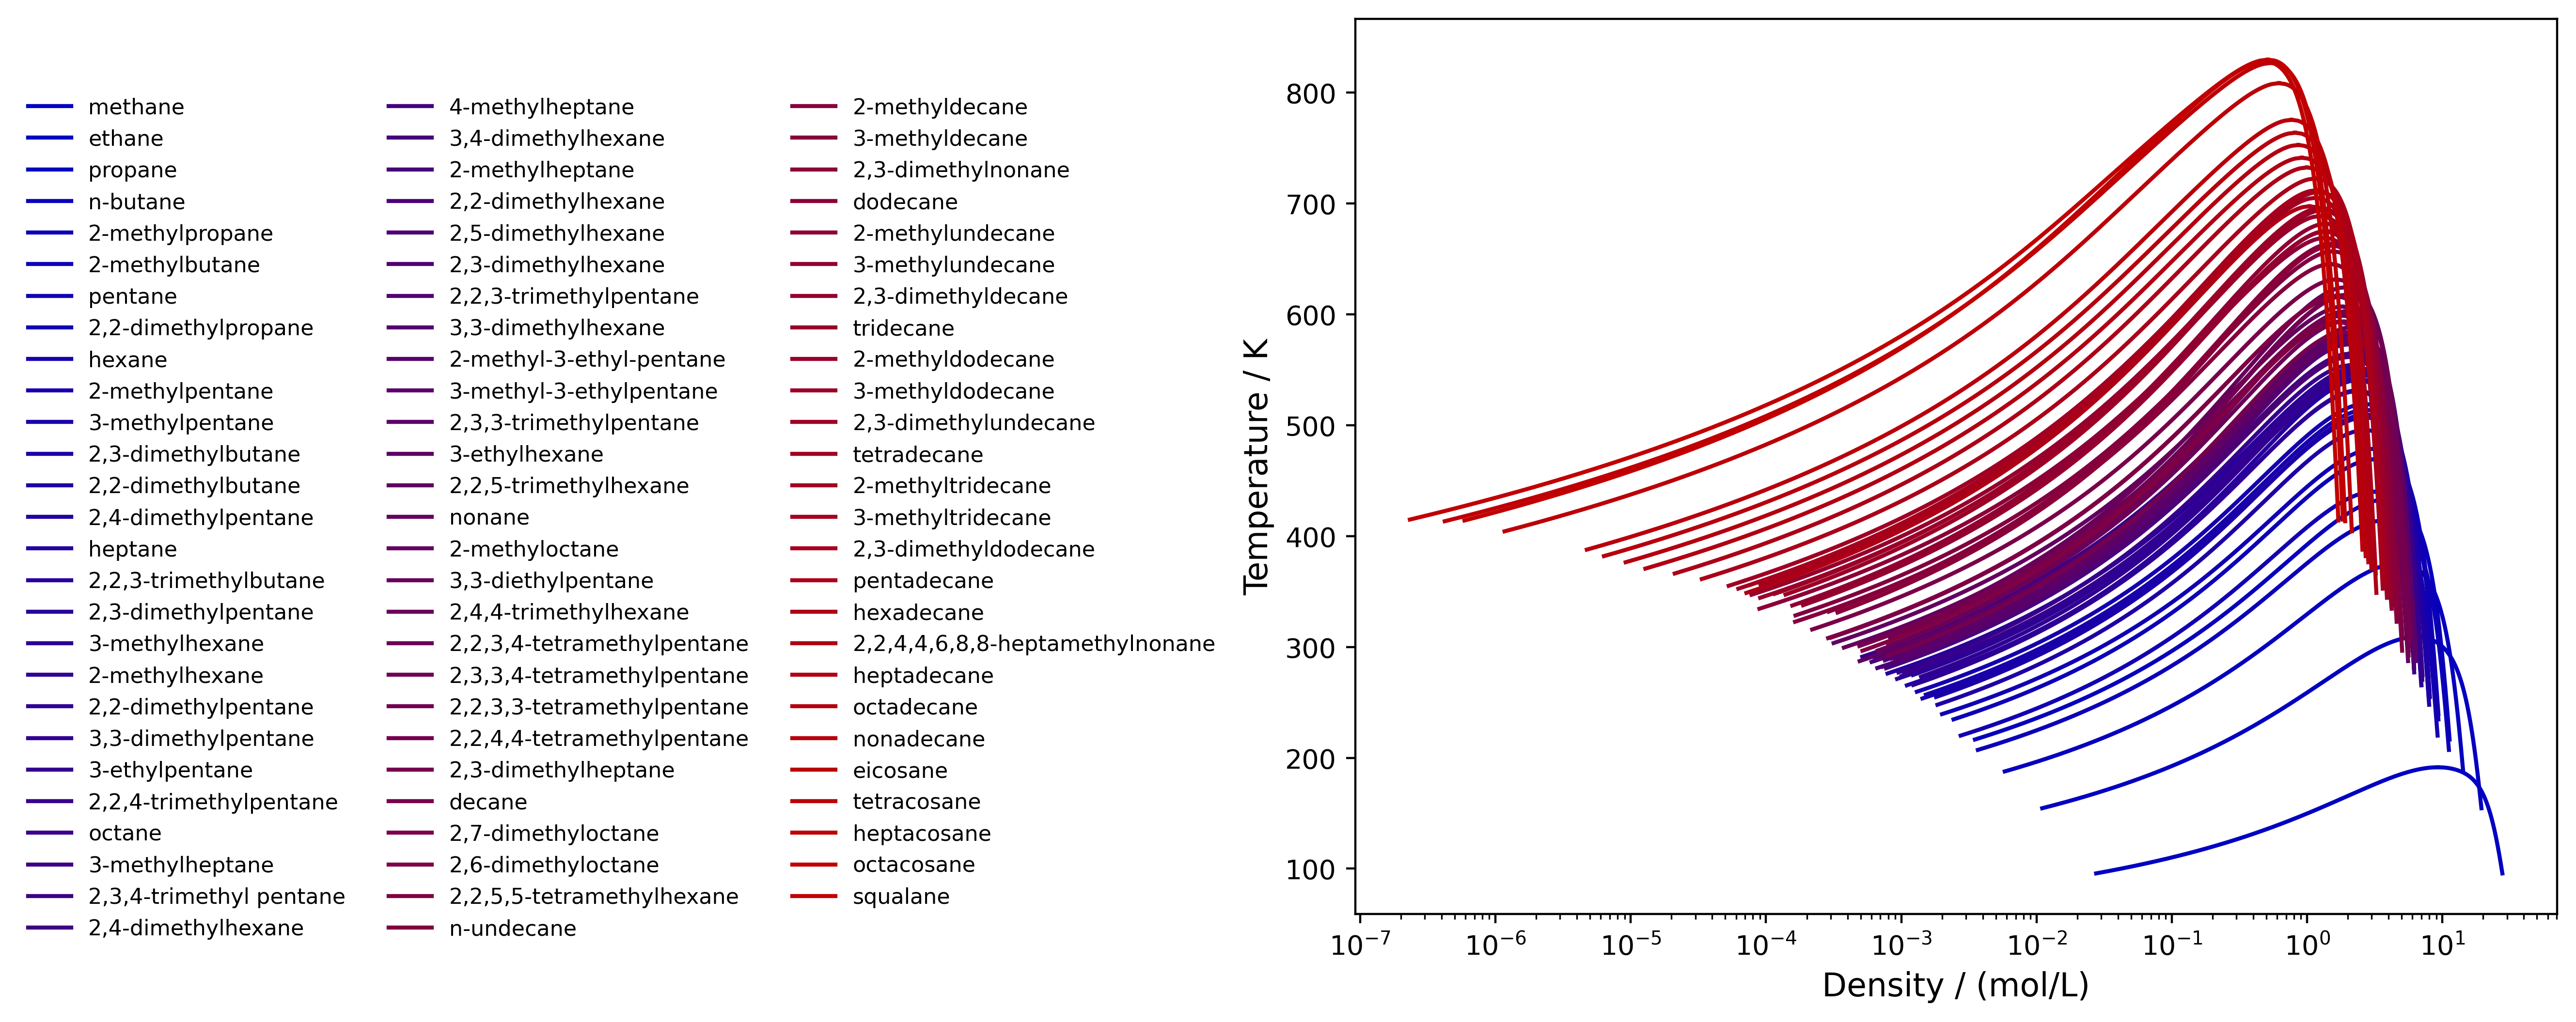

In [51]:
colour_grad_1 = collect(range(1,194,length(species_names)) ./255) 
colour_grad_2 = collect(range(194,1,length(species_names)) ./255)

plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(species_names)

plt.semilogx(1e-3 ./sat_vols_liq[i],temp_ranges[i],label=species_names[i], color = [colour_grad_1[i] 0 colour_grad_2[i]])
plt.semilogx(1e-3 ./sat_vols_vap[i],temp_ranges[i],color = [colour_grad_1[i] 0 colour_grad_2[i]])

end

plt.legend(loc="lower right",bbox_to_anchor =(-0.1,-0.05),frameon=false,fontsize=8,ncol=3) 
plt.xlabel("Density / (mol/L)",fontsize=12)
plt.ylabel("Temperature / K",fontsize=12)

plt.savefig("alkane_envelopes.png",dpi=400)


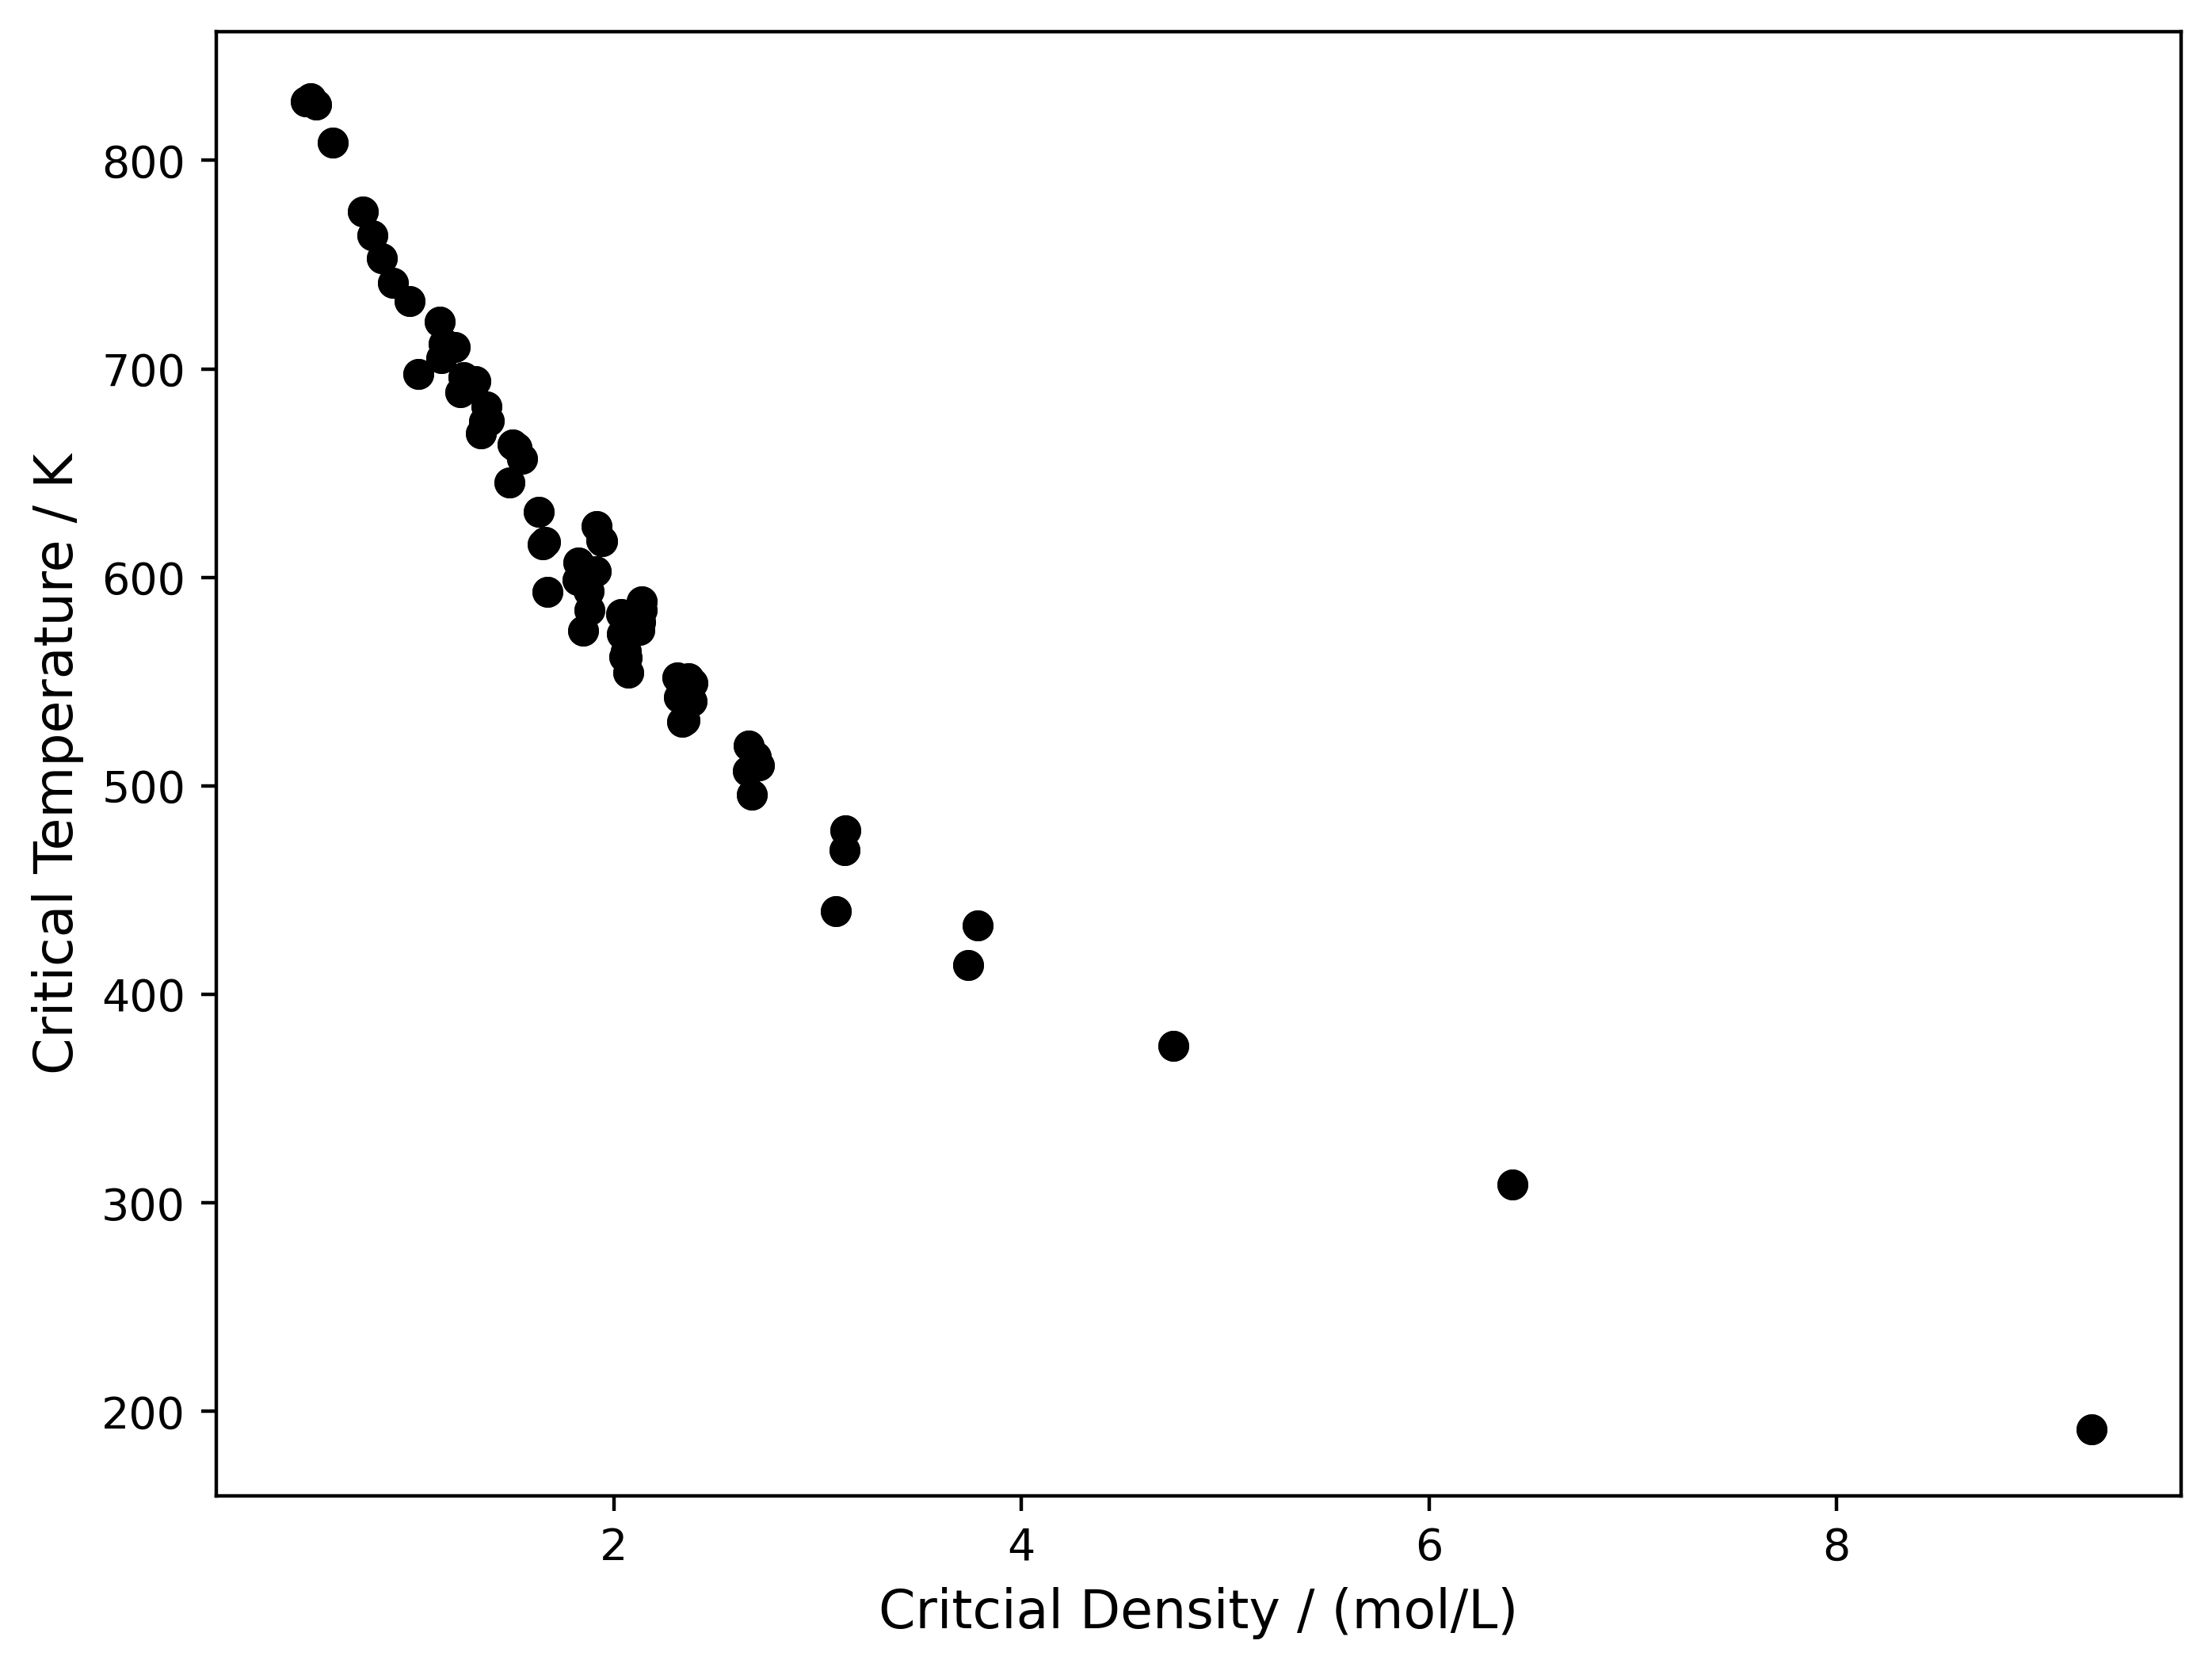

In [38]:
plt.figure(figsize=(8, 6), dpi=400)

for i = 1:length(species_names)
plt.scatter(1e-3 ./critical_props[i][3],critical_props[i][1], color = "black")
plt.scatter(1e-3 ./critical_props[i][3],critical_props[i][1],color = "black")
end

plt.xlabel("Critcial Density / (mol/L)",fontsize=12)
plt.ylabel("Critical Temperature / K",fontsize=12)
plt.savefig("alkane_envelopes.png",dpi=400)


In [39]:
test_species_exptl_data = DataFrame(CSV.File("test_species_exptl_data.csv")) ; 

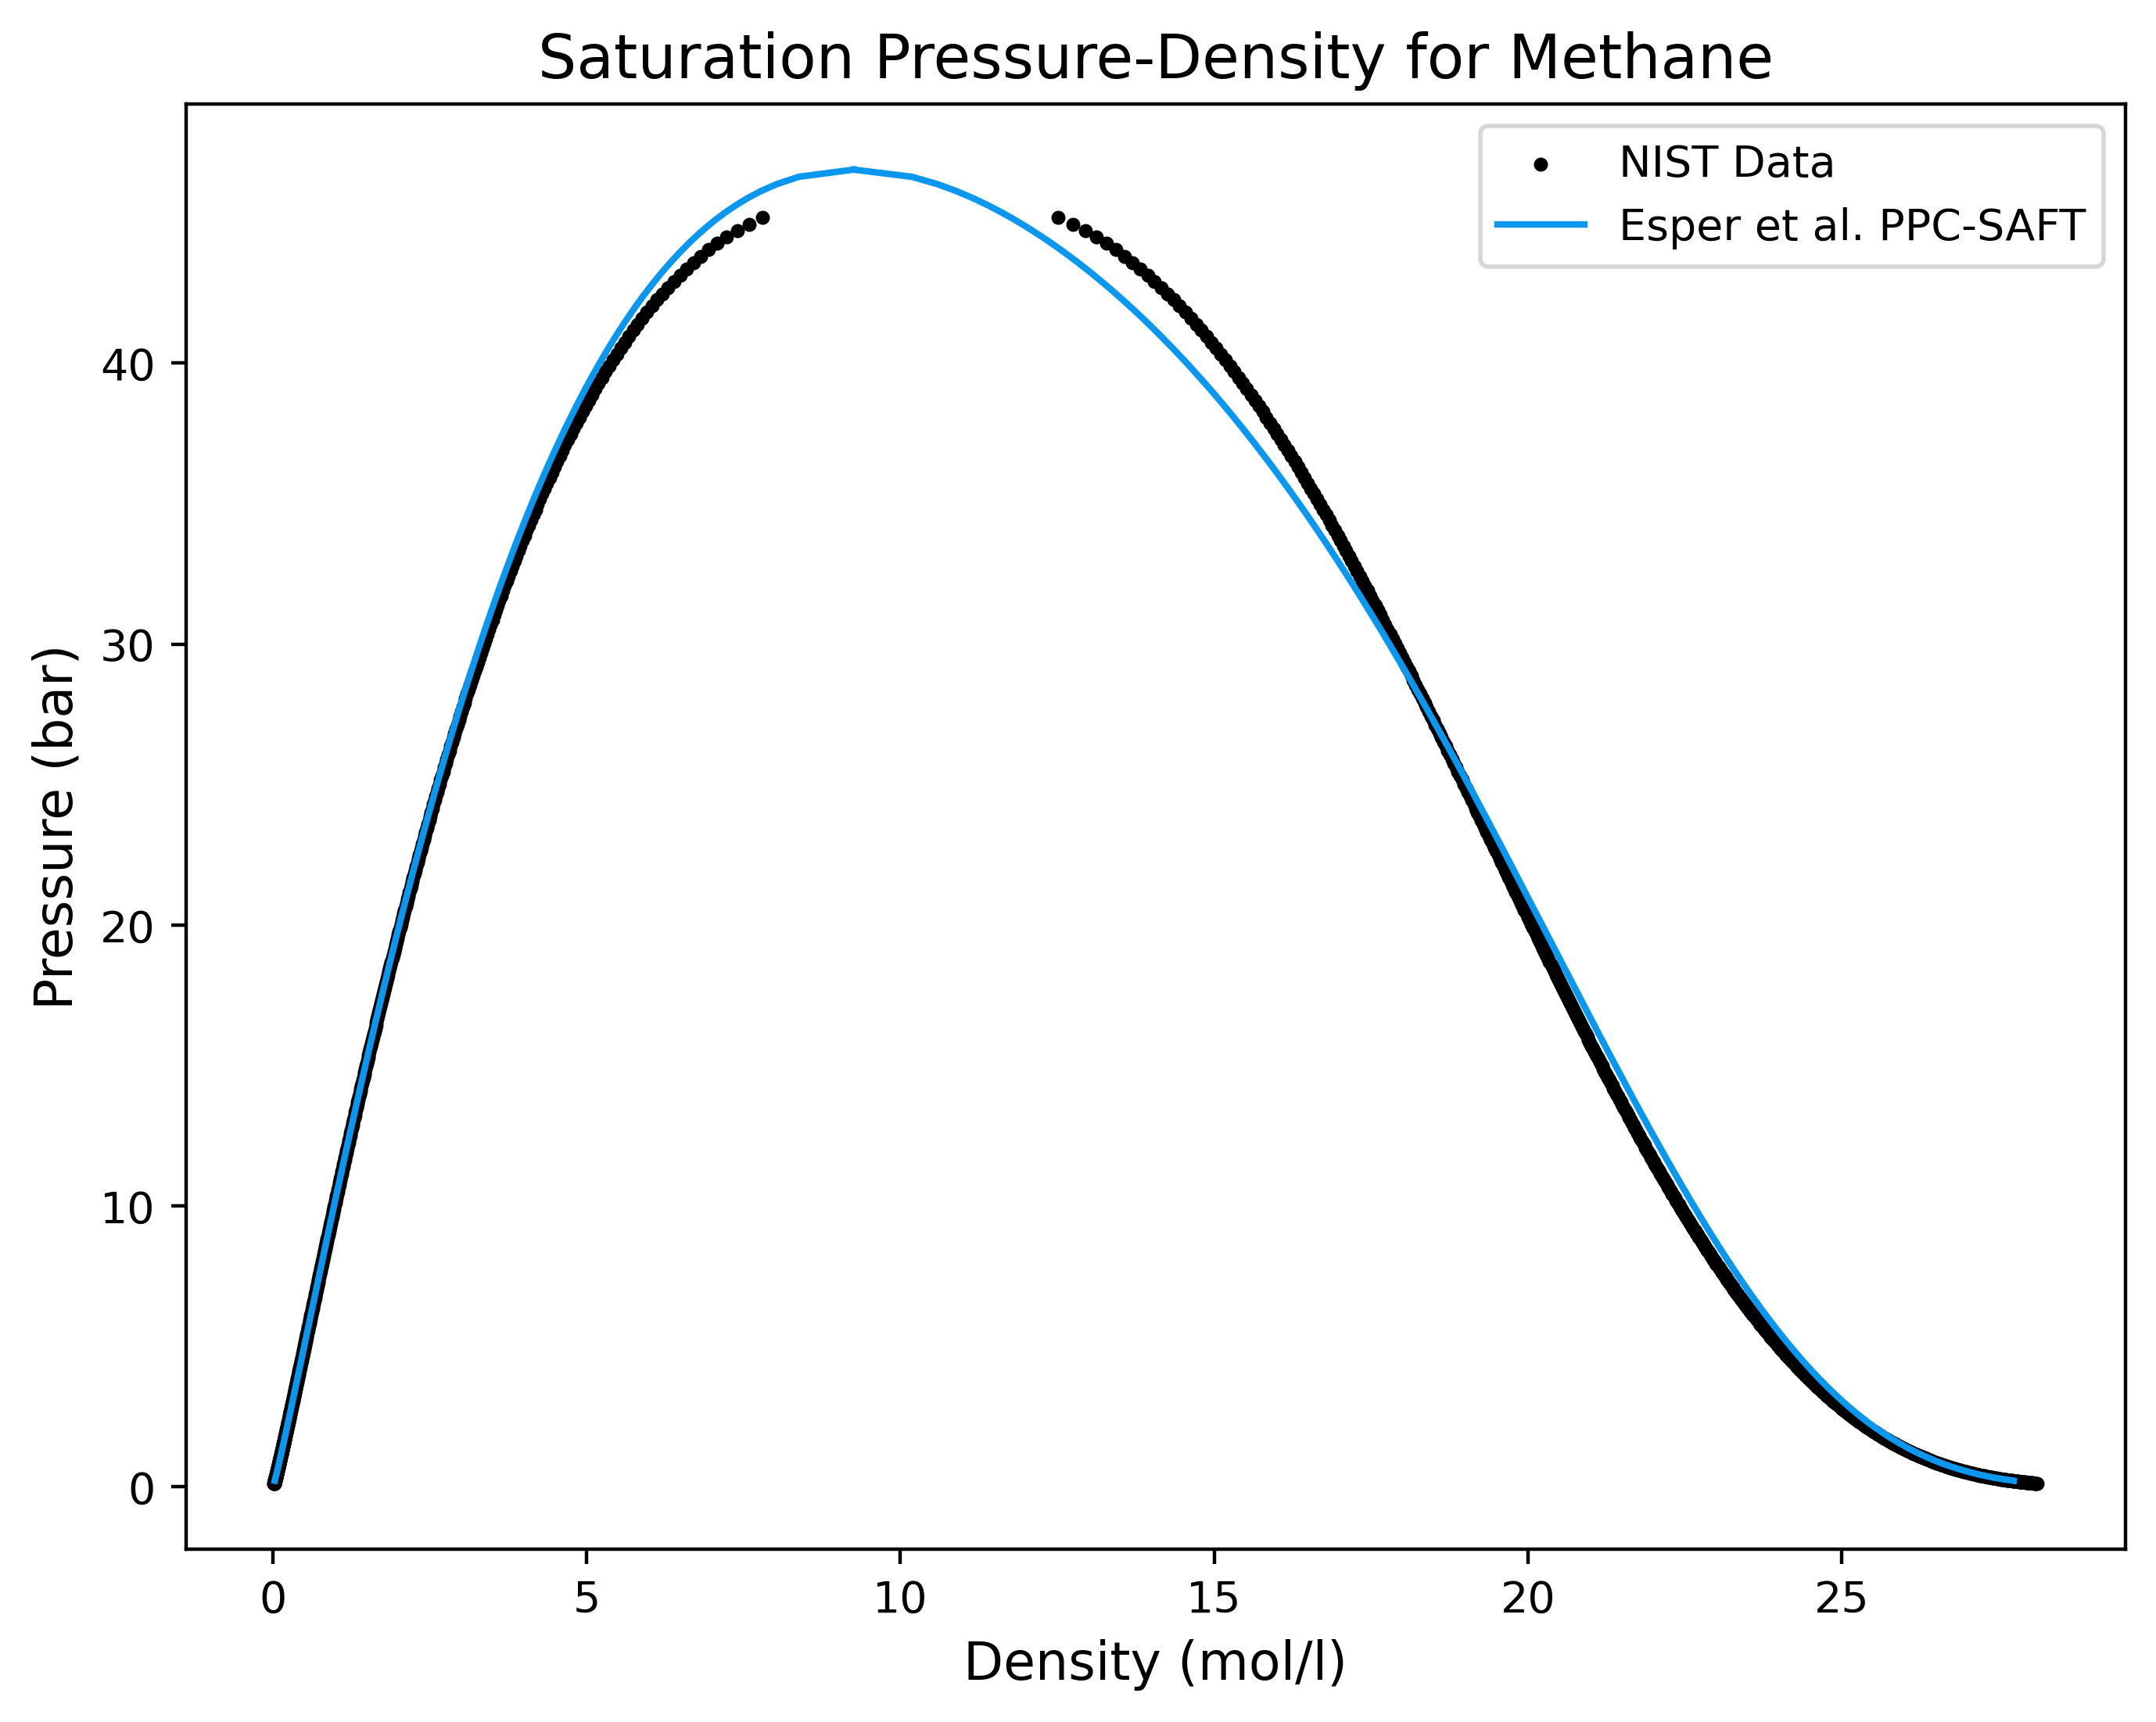

In [52]:
plt.figure(figsize=(8, 6), dpi=400)

plt.scatter(test_species_exptl_data[!,"Density (mol/l)"] ./1000,test_species_exptl_data[!,"Pressure (bar)"],s=5,color="black")
plt.plot(1e-3 ./sat_vols_vap[1],sat_pressures[1] ./10^5, color="#0a97f0")
plt.plot(1e-3 ./sat_vols_liq[1],sat_pressures[1] ./10^5, color="#0a97f0")

plt.title("Saturation Pressure-Density for Methane",fontsize=14)
plt.xlabel("Density [mol/l]",fontsize=12)
plt.ylabel("Pressure [bar]",fontsize=12)

plt.xlabel("Density (mol/l)") ;
plt.ylabel("Pressure (bar)") ;
plt.legend(["NIST Data","Esper et al. PPC-SAFT"]) ;